#### Importing required libraries

In [1]:
import pandas as pd
import networkx as nx
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import print

#### Read the data from github (Loading author network data)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/umassdgithub/Fall-2023-DataViz/main/Week-8-ForceSimulator/data/data_scopus.csv")

In [3]:
df.head(2)

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN


In [4]:
# Dropping the columns which do not have values for the below
df = df.dropna(subset=['Author(s) ID','Year','Authors','Authors with affiliations'])

In [5]:
df=df.fillna(0)

<Axes: >

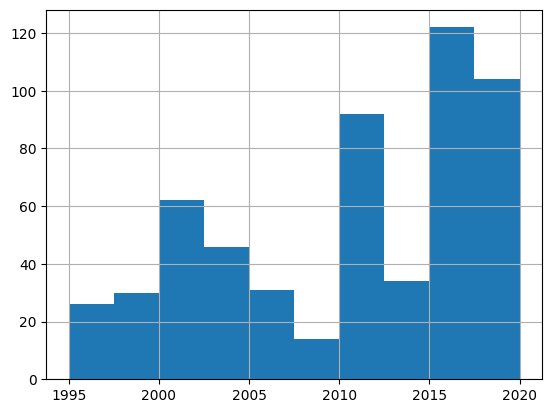

In [6]:
df.Year.hist()

In [7]:
df['Year'].min()

1995

In [8]:
df['Year'].max()

2020

In [9]:
G = nx.Graph()

#### Creating Authors as Nodes

In [10]:
nodes = {}
for _, row in df.iterrows():
    # Extract authors from the "Authors" column
    authors = row['Authors'].split(',')
    author_Id = row['Author(s) ID'].split(';')
    Title=row['Title']
    Year=row['Year']
    Citations=row['Cited by']
    Publisher=row['Publisher']
    auth_w_aff=row['Authors with affiliations']

    # Adding authors as nodes

    for author in range(len(authors)):

        aid= author_Id[author]
        auth_name= ';'.join(authors)
        title=Title

        if(aid!=""):
         nodes={'id':aid,
          "Authors": auth_name,
          "Title": title,
          "Year": Year,
          "Citations": Citations,
          "Publisher": Publisher,
          "Author with affiliations":auth_w_aff
           }
         G.add_node(aid,**nodes)

In [11]:
nodes

{'id': '7103384676',
 'Authors': 'Hoskins J.A.; Hoskins W.D.',
 'Title': 'Ray tracing as a tool for visualization of pathogen spread in natural forest stands',
 'Year': 1995,
 'Citations': 0.0,
 'Publisher': 'ACM, New York, NY, United States',
 'Author with affiliations': 'Hoskins, J.A., Univ of Manitoba, Winnipeg, Canada; Hoskins, W.D., Univ of Manitoba, Winnipeg, Canada'}

In [12]:
len(G)

1552

In [13]:
from networkx.readwrite import json_graph
with open("publication_network.json", "w") as f:
    json.dump(json_graph.node_link_data(G), f)

#### Creating Edges

In [14]:
# Load the data from the JSON file
with open('publication_network.json', 'r') as infile:
    data = json.load(infile)
newnodes=[]

In [15]:
G=nx.Graph()

In [16]:
def get_author_country(authors_with_affiliations):
    first_affiliation = authors_with_affiliations.split(';')[0].strip()
    country = first_affiliation.split(',')[-1].strip()
    return country


In [17]:
for node_data in data['nodes']:
    eid = node_data.get('id')
    authors=node_data.get('Authors')
    title = node_data.get('Title')
    year = node_data.get('Year')
    citations = node_data.get('Citations')
    publisher = node_data.get('Publisher')

    authors_with_affiliations = str(node_data.get('Author with affiliations'))

    country = get_author_country(authors_with_affiliations)

    G.add_node(eid,authors=authors, title=title, year=year, citations=citations, publisher=publisher,authors_with_affiliations=authors_with_affiliations, country=country)

#### Generating clusters based on author's countries

In [18]:
clusters = list(nx.connected_components(G))

#Assigning class
class_mapping = {node: idx for idx, cluster in enumerate(clusters) for node in cluster}
nx.set_node_attributes(G, class_mapping, 'class')

In [19]:
#As we want a relationship between author and co-author, creating a dictionary to store the co-authors
coauthorship_dict = {}
for row in df.iterrows():
    authors = row[1]['Author(s) ID'].split(';')
    for i in range(len(authors)):
      for j in range(i+1, len(authors)):
        if(authors[i]!="" and authors[j]!=""):
          G.add_edge(authors[i], authors[j])

In [20]:
G

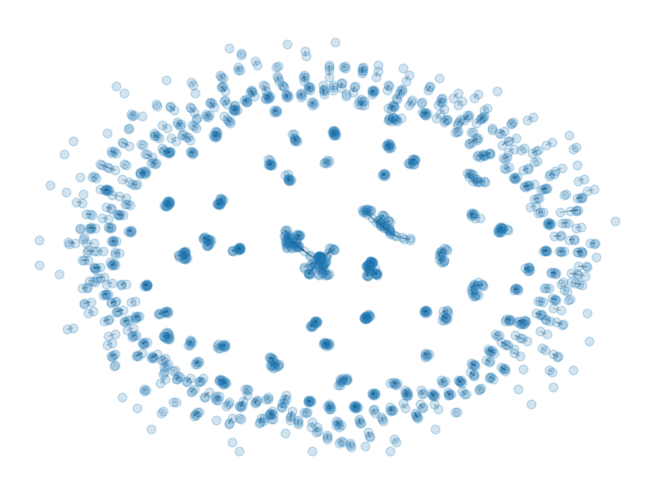

In [21]:
pos = nx.spring_layout(G)
nx.draw(G,pos=pos, node_size=40,alpha=.2)

In [22]:
# Save the data as a JSON file with proper character encoding
coauthorship_data = {'nodes': [{'id': node, **G.nodes[node]} for node in G.nodes()],'links': [{'source': source, 'target': target} for source, target in G.edges()]}

In [23]:
with open('coauthors.json', 'w', encoding='utf-8') as outfile:
    json.dump(coauthorship_data, outfile, ensure_ascii=False)